# Optimal Baseball

*Modeling and Simulation in Python*

Copyright 2021 Allen Downey

License: [Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International](https://creativecommons.org/licenses/by-nc-sa/4.0/)

In [1]:
# install Pint if necessary

try:
    from pint import UnitRegistry
except ImportError:
    !pip install pint
    
# import units
from pint import UnitRegistry
units = UnitRegistry()

In [2]:
# download modsim.py if necessary

from os.path import basename, exists

def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve
        local, _ = urlretrieve(url, filename)
        print('Downloaded ' + local)
    
download('https://github.com/AllenDowney/ModSimPy/raw/master/' +
         'modsim.py')

In [3]:
# import functions from modsim

from modsim import *

This chapter is available as a Jupyter notebook where you can read the text, run the code, and work on the exercises. 
Click here to access the notebooks: <https://allendowney.github.io/ModSimPy/>.

In [4]:
download('https://github.com/AllenDowney/ModSimPy/raw/master/' +
         'chap22.py')

In [5]:
# import functions from previous notebook

from chap22 import params
from chap22 import make_system
from chap22 import slope_func
from chap22 import event_func

In the previous chapter we developed a model of the flight of a
baseball, including gravity and a simple version of drag, but neglecting spin, Magnus force, and the dependence of the coefficient of drag on velocity.

In this chapter we apply that model to an optimization problem. In general, *optimization* is a process for improving a design by searching for the parameters that maximize a benefit or minimize a cost. For example, in this chapter we'll find the angle you should hit a baseball to maximize the distance it travels. And we'll use a new function, called `maximize_scalar` that searches for this angle efficiently.

## The Manny Ramirez Problem

Manny Ramirez is a former member of the Boston Red Sox (an American
baseball team) who was notorious for his relaxed attitude and taste for practical jokes. Our objective in this chapter is to solve the following Manny-inspired problem:

> What is the minimum effort required to hit a home run in Fenway Park?

Fenway Park is a baseball stadium in Boston, Massachusetts. One of its
most famous features is the "Green Monster", which is a wall in left
field that is unusually close to home plate, only 310 feet away. To
compensate for the short distance, the wall is unusually high, at 37
feet (see <http://modsimpy.com/wally>).

Starting with `params` from the previous chapter, I'll make a new `Params` object with two additional parameters, `wall_distance` and `wall_height`, in meters.

In [6]:
feet_to_meter = (1 * units.feet).to(units.meter).magnitude

params = params.set(
    wall_distance = 310 * feet_to_meter,
    wall_height = 37 * feet_to_meter,
)

show(params)

,value
x,0.0000
y,1.0000
angle,45.0000
speed,40.0000
mass,0.1450
diameter,0.0730
C_d,0.3300
rho,1.2000
g,9.8000
t_end,10.0000


The answer we want is the minimum speed at which a ball can leave home plate and still go over the Green Monster. We'll proceed in the
following steps:

1.  For a given speed, we'll find the optimal *launch angle*, that is, the angle the ball should leave home plate to maximize its height when it reaches the wall.

2.  Then we'll find the minimum speed that clears the wall, given
    that it has the optimal launch angle.

## Finding the Range

Suppose we want to find the launch angle that maximizes *range*, that is, the distance the ball travels in the air before landing. We'll use a function in the ModSim library, `maximize_scalar`, which takes a function and finds its maximum.

The function we pass to `maximize_scalar` should take launch angle in degrees, simulate the flight of a ball launched at that angle, and return the distance the ball travels along the $x$ axis.

In [7]:
def range_func(angle, params):
    params = params.set(angle=angle)
    system = make_system(params)
    results, details = run_solve_ivp(system, slope_func,
                                     events=event_func)
    x_dist = results.iloc[-1].x
    print(angle, x_dist)
    return x_dist

`range_func` makes a new `System` object with the given value of
`angle`. Then it calls `run_solve_ivp` and
returns the final value of `x` from the results.

We can call `range_func` directly like this:

In [8]:
range_func(45, params)

45 99.31829628352213


99.31829628352213

With launch angle 45°, the ball lands about 99 meters from home plate.

Now we can sweep a sequence of angles like this:

In [9]:
angles = linspace(20, 80, 21)
sweep = SweepSeries()

for angle in angles:
    x_dist = range_func(angle, params)
    sweep[angle] = x_dist

20.0 78.09741067882733
23.0 84.11542610650983
26.0 89.1319241236397
29.0 93.17466724082831
32.0 96.27134737391347
35.0 98.44725560274013
38.0 99.72474586365286
41.0 100.12347299697637
44.0 99.66100302635327
47.0 98.35354763684836
50.0 96.21673516565127
53.0 93.26623796736264
56.0 89.51751617672979
59.0 84.98724481958084
62.0 79.69434524339994
65.0 73.66129770133254
68.0 66.91470886279747
71.0 59.48269492939761
74.0 51.40287109940439
77.0 42.72047925533449
80.0 33.48437980813933


Here's what the results look like.

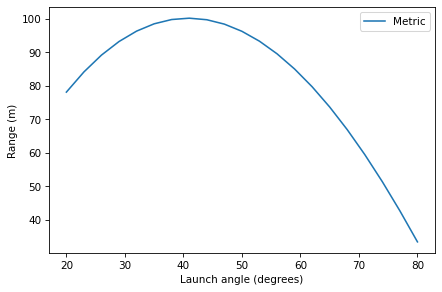

In [10]:
sweep.plot()

decorate(xlabel='Launch angle (degrees)',
         ylabel='Range (m)')

It looks like the range is maximized when the initial angle is near 40°.
We can find the optimal angle more precisely and more efficiently using `maximize_scalar`, like this:

In [11]:
res = maximize_scalar(range_func, params, bounds=[0, 90])

0 17.468795355645703
34.37694101250946 98.06996498016372
55.62305898749054 90.03182421721925
21.246117974981075 80.72039493627989
41.173855871043976 100.1200188931698
40.980120907837964 100.12368377099199
40.88213731907024 100.12417004431842
40.879254201241096 100.12417043309692
40.879287138759004 100.12417043314979
40.87929107843015 100.12417043314908
40.87928319908786 100.1241704331489


The first parameter is the function we want to maximize. The second is
the range of values we want to search; in this case, it's the range of
angles from 0° to 90°. 

The return value from `maximize_scalar` is an object that contains the
results, including `x`, which is the angle that yielded the maximum
range, and `fun`, which is the range when the ball is launched at the optimal angle.

In [12]:
res

 message: Solution found.
 success: True
  status: 0
     fun: 100.12417043314979
       x: 40.879287138759004
     nit: 10
    nfev: 10

In [13]:
res.x, res.fun

(40.879287138759004, 100.12417043314979)

For these parameters, the optimal angle is about 41°, which yields a range of 100 m.
Now we have what we need to finish the problem; the last step is to find the minimum velocity needed to get the ball over the wall. In the exercises at the end of the chapter, I provide some suggestions. Then it's up to you!

## Summary

This chapter introduces a new tool, `maximize_scalar`, that provides an efficient way to search for the maximum of a function. We used it to find the launch angle that maximizes the distance a baseball flies through the air, given its initial velocity.

If you enjoy this example, you might be interested in this paper: "How to hit home runs: Optimum baseball bat swing parameters for maximum range trajectories", by Sawicki, Hubbard, and Stronge, at <http://modsimpy.com/runs>.

In the next chapter, we start a new topic: rotation!

## Exercises

This chapter is available as a Jupyter notebook where you can read the text, run the code, and work on the exercises. 
You can access the notebooks at <https://allendowney.github.io/ModSimPy/>.

### Exercise 1

Let's finish off the Manny Ramirez problem:

> What is the minimum effort required to hit a home run in Fenway Park?

Although the problem asks for a minimum, it is not an optimization problem.  Rather, we want to solve for the initial speed that just barely gets the ball to the top of the wall, given that it is launched at the optimal angle.

And we have to be careful about what we mean by "optimal".  For this problem, we don't want the longest range; we want the maximum height at the point where it reaches the wall.

If you are ready to solve the problem on your own, go ahead.  Otherwise I will walk you through the process with an outline and some starter code.

As a first step, write an `event_func` that stops the simulation when the ball reaches the wall at `wall_distance`, which is a parameter in `params`.
Test your function with the initial conditions.

In [14]:
# Solution goes here
import numpy as np
from scipy.integrate import solve_ivp
from scipy.optimize import minimize_scalar, root_scalar

# Define the derivatives function for projectile motion
def derivatives(t, y, params):
    g = 9.81  # acceleration due to gravity (m/s^2)
    x, y_pos, vx, vy = y
    dydt = [vx, vy, 0, -g]
    return dydt

# Define the event function to stop the simulation when the ball reaches the wall
def event_func(t, y, params):
    x, y_pos, vx, vy = y
    wall_distance = params['wall_distance']
    return x - wall_distance

event_func.terminal = True
event_func.direction = 1

# Define the height function to return the height of the baseball when it reaches the wall
def height_func(angle, initial_speed, params):
    angle_rad = np.radians(angle)
    vx = initial_speed * np.cos(angle_rad)
    vy = initial_speed * np.sin(angle_rad)
    initial_conditions = [0, 0, vx, vy]
    
    t_eval = np.linspace(0, 10, 1000)
    result = solve_ivp(derivatives, [0, 10], initial_conditions, args=(params,), events=event_func, t_eval=t_eval)
    
    if result.t_events[0].size > 0:
        y_at_wall = result.y[1, np.argmax(result.t_events[0])]
        print(f"Height at wall for speed {initial_speed} m/s and angle {angle} degrees: {y_at_wall} meters")
        return y_at_wall
    else:
        print(f"Ball did not reach the wall for speed {initial_speed} m/s and angle {angle} degrees")
        return -np.inf  # If the ball doesn't reach the wall, return a very low value

# Define the function to find the optimal angle
def optimal_angle_func(speed, params):
    result = minimize_scalar(lambda angle: -height_func(angle, speed, params), bounds=(0, 90), method='bounded')
    return result.x

# Define the error function for root finding
def error_func(speed, params):
    optimal_angle = optimal_angle_func(speed, params)
    height_at_wall = height_func(optimal_angle, speed, params)
    wall_height = params['wall_height']
    return height_at_wall - wall_height

# Main function to find the minimum speed required to hit a home run
def find_minimum_speed(params):
    # Initial bracket
    lower_bound = 50
    upper_bound = 500
    
    # Check the signs at the initial bounds and adjust if necessary
    while True:
        error_at_lower = error_func(lower_bound, params)
        error_at_upper = error_func(upper_bound, params)
        print(f"Error at speed {lower_bound}: {error_at_lower}")
        print(f"Error at speed {upper_bound}: {error_at_upper}")
        
        if error_at_lower * error_at_upper < 0:
            break
        else:
            # Adjust bounds to find a valid bracket
            if error_at_lower < 0:
                lower_bound /= 2
            else:
                upper_bound *= 2

    # Use root_scalar to find the minimum speed
    result = root_scalar(error_func, args=(params,), bracket=[lower_bound, upper_bound], method='bisect')
    if result.converged:
        min_speed = result.root
        return min_speed
    else:
        raise ValueError("Root finding did not converge")

# Example parameters for Fenway Park
params = {'wall_distance': 310, 'wall_height': 37}

# Find the minimum speed required
min_speed = find_minimum_speed(params)
print(f"Minimum speed to hit a home run: {min_speed} m/s")

# Verify the result
verification_error = error_func(min_speed, params)
print(f"Verification error at speed {min_speed}: {verification_error}")


Height at wall for speed 50 m/s and angle 34.37694101250946 degrees: 0.0 meters
Ball did not reach the wall for speed 50 m/s and angle 55.62305898749054 degrees
Height at wall for speed 50 m/s and angle 21.246117974981075 degrees: 0.0 meters
Height at wall for speed 50 m/s and angle 13.130823037528394 degrees: 0.0 meters
Height at wall for speed 50 m/s and angle 8.115294937452685 degrees: 0.0 meters
Height at wall for speed 50 m/s and angle 5.015528100075711 degrees: 0.0 meters
Height at wall for speed 50 m/s and angle 3.099766837376974 degrees: 0.0 meters
Height at wall for speed 50 m/s and angle 1.915761262698738 degrees: 0.0 meters
Height at wall for speed 50 m/s and angle 1.184005574678236 degrees: 0.0 meters
Height at wall for speed 50 m/s and angle 0.7317556880205018 degrees: 0.0 meters
Height at wall for speed 50 m/s and angle 0.4522498866577344 degrees: 0.0 meters
Height at wall for speed 50 m/s and angle 0.2795058013627675 degrees: 0.0 meters
Height at wall for speed 50 m/s an

c:\Users\gerra\miniconda3\envs\pcd\lib\site-packages\scipy\optimize\_optimize.py:2290: RuntimeWarning: invalid value encountered in scalar multiply
  q = (xf - fulc) * (fx - fnfc)


Ball did not reach the wall for speed 6.25 m/s and angle 89.99998858041343 degrees
Ball did not reach the wall for speed 6.25 m/s and angle 89.99999324866232 degrees
Ball did not reach the wall for speed 6.25 m/s and angle 89.99999324866232 degrees
Height at wall for speed 500 m/s and angle 34.37694101250946 degrees: 0.0 meters
Height at wall for speed 500 m/s and angle 55.62305898749054 degrees: 0.0 meters
Height at wall for speed 500 m/s and angle 68.75388202501892 degrees: 0.0 meters
Height at wall for speed 500 m/s and angle 76.86917696247161 degrees: 0.0 meters
Height at wall for speed 500 m/s and angle 81.88470506254733 degrees: 0.0 meters
Height at wall for speed 500 m/s and angle 84.9844718999243 degrees: 0.0 meters
Ball did not reach the wall for speed 500 m/s and angle 86.90023316262304 degrees
Height at wall for speed 500 m/s and angle 83.80046632524606 degrees: 0.0 meters
Height at wall for speed 500 m/s and angle 83.06871063722556 degrees: 0.0 meters
Height at wall for spe

KeyboardInterrupt: 

Next, write a function called `height_func` that takes a launch angle, simulates the flight of a baseball, and returns the height of the baseball when it reaches the wall.
Test your function with the initial conditions.

In [ ]:
# Solution goes here

In [ ]:
# Solution goes here

Now use `maximize_scalar` to find the optimal angle.  Is it higher or lower than the angle that maximizes range?

In [ ]:
# Solution goes here

In [ ]:
# Solution goes here

The angle that maximizes the height at the wall is a little higher than the angle that maximizes range.

Now, let's find the initial speed that makes the height at the wall exactly 37 feet, given that it's launched at the optimal angle. 
This is a root-finding problem, so we'll use `root_scalar`.

Write an error function that takes a speed and a `System` object as parameters.  It should use `maximize_scalar` to find the highest possible height of the ball at the wall, for the given speed.  Then it should return the difference between that optimal height and `wall_height`, which is a parameter in `params`.

In [ ]:
# Solution goes here

Test your error function before you call `root_scalar`.

In [ ]:
# Solution goes here

In [ ]:
# Solution goes here

Then use `root_scalar` to find the answer to the problem, the minimum speed that gets the ball out of the park.

In [ ]:
# Solution goes here

In [ ]:
# Solution goes here

In [ ]:
# Solution goes here

And just to check, run `error_func` with the value you found.

In [ ]:
# Solution goes here

## Under the Hood

`maximize_scalar` uses a SciPy function called `minimize_scalar`, which provides several optimization methods.  By default, it uses `bounded`, a version of Brent's algorithm that is safe in the sense that it always uses values within the bounds you provide (including both ends).
You can read more about it at <http://modsimpy.com/minimize>).